In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import tempfile
import pyabc

import healpy as hp
from scipy.special import sph_harm
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
from abc_for_qso import model, distance
from run_analysis import analyze_Cells
import generate_mocks as gm

## data for Quaia and CatWISE

In [3]:
blim = 30
nside_hi = 64
resdir = '/scratch/aew492/lss-dipoles_results/results'

#### Quaia

In [4]:
# selfunc
selfunc_quaia = gm.get_selfunc_map('quaia_G20.0_orig', nside=nside_hi, blim=blim)

# load data
# masked
quaia_qmap = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked.npy'))
# the above map smoothed to 1sr
quaia_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_smoothed_1sr.npy'))
# correct by selfunc
quaia_qmap_corr = quaia_qmap / selfunc_quaia
# load the selfunc-corrected, smoothed map
quaia_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_corr_smoothed_1sr.npy'))

# base rate for mocks
base_rate_quaia = 33.6330

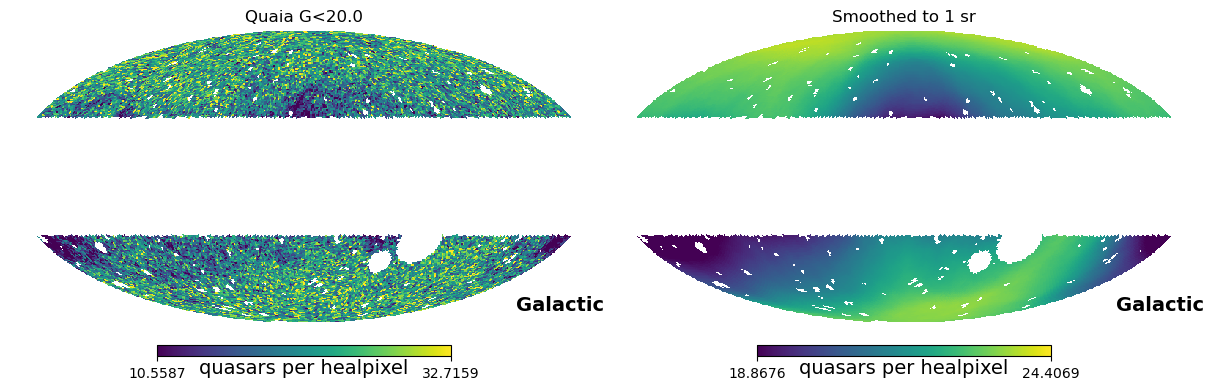

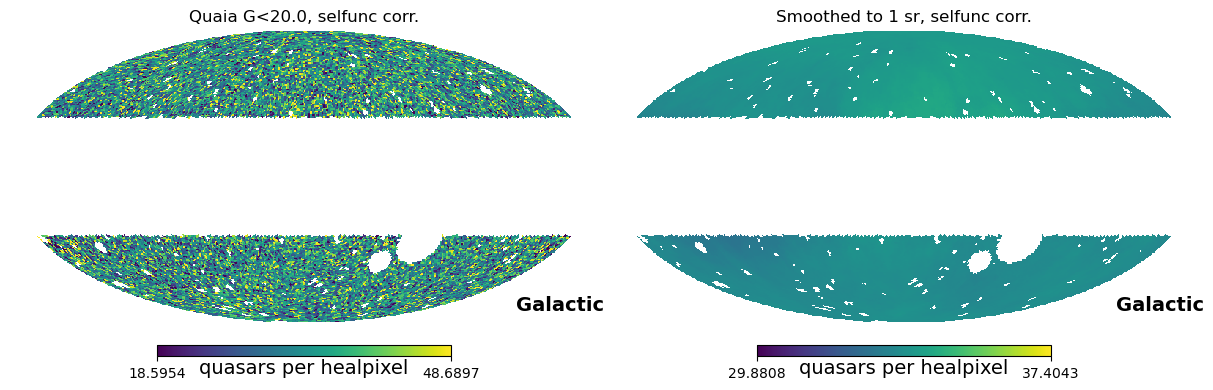

In [5]:
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(quaia_qmap), np.nanstd(quaia_qmap)
hp.mollview(quaia_qmap, min=mean-2*std, max=mean+2*std, title='Quaia G<20.0', sub=(1,2,1), **kwargs)
hp.mollview(quaia_qmap_smoothed, min=mean-0.5*std, max=mean+0.5*std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(quaia_qmap_corr), np.nanstd(quaia_qmap_corr)
hp.mollview(quaia_qmap_corr, min=mean-2*std, max=mean+2*std, title='Quaia G<20.0, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(quaia_qmap_corr_smoothed, min=mean-0.5*std, max=mean+0.5*std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

#### CatWISE

In [6]:
# selfunc
selfunc_catwise = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim)

# load data
# masked
catwise_qmap = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked.npy'))
# the above map smoothed to 1sr
catwise_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_smoothed_1sr.npy'))
# selfunc-corrected
catwise_qmap_corr = catwise_qmap / selfunc_catwise
# selfunc-corrected and smoothed
catwise_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_smoothed_1sr.npy'))

# base rate for mocks
base_rate_catwise = 77.4495

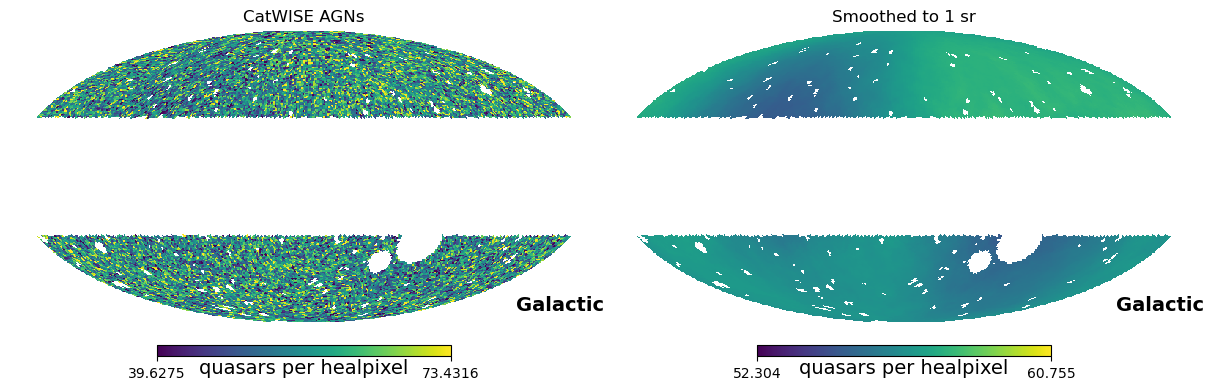

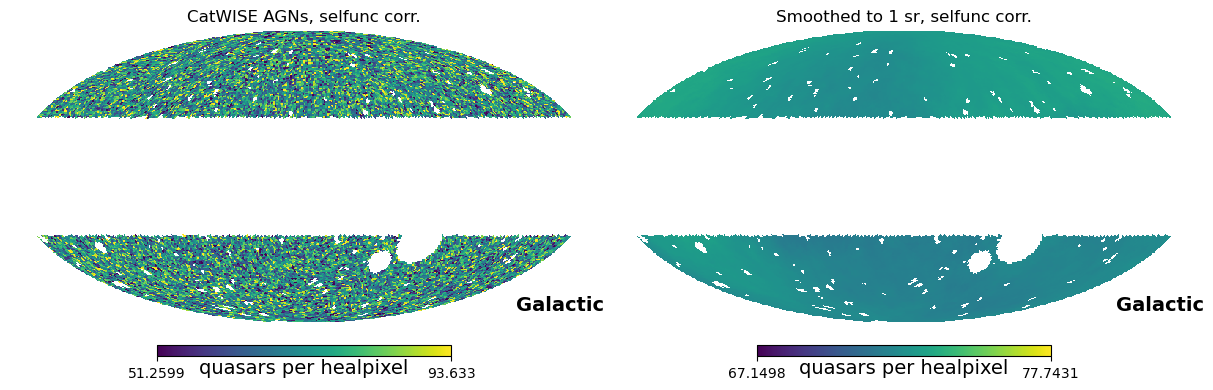

In [7]:
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(catwise_qmap), np.nanstd(catwise_qmap)
hp.mollview(catwise_qmap, min=mean-2*std, max=mean+2*std, title='CatWISE AGNs', sub=(1,2,1), **kwargs)
hp.mollview(catwise_qmap_smoothed, min=mean-0.5*std, max=mean+0.5*std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(catwise_qmap_corr), np.nanstd(catwise_qmap_corr)
hp.mollview(catwise_qmap_corr, min=mean-2*std, max=mean+2*std, title='CatWISE AGNs, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(catwise_qmap_corr_smoothed, min=mean-0.5*std, max=mean+0.5*std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

## Quaia

### nside = 1

In [8]:
nside = 1
res = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_20iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']
selfunc = res['selfunc']

Text(0.5, 0.98, 'Quaia ABC posteriors, nside=1, 18 generations')

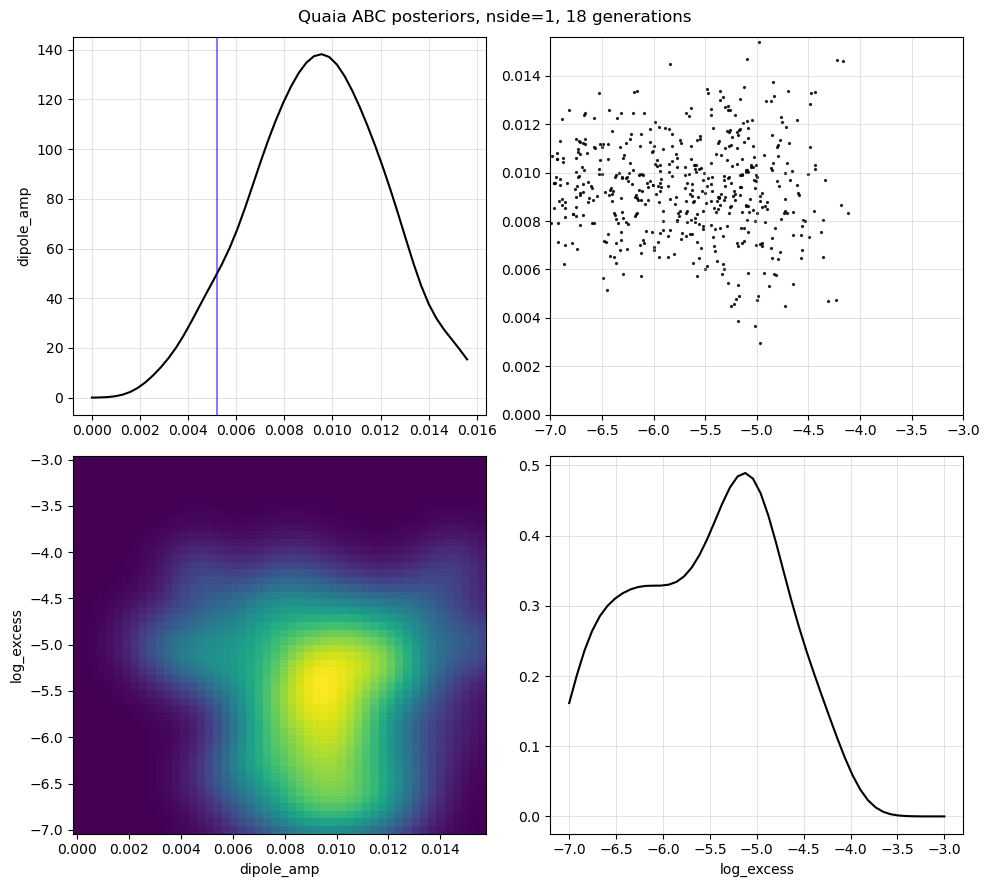

In [9]:

# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)
    if i == 0:
        ax.axvline(0.0052, c='b', alpha=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'Quaia ABC posteriors, nside={nside}, {history.max_t} generations')

In [10]:
# median posterior
np.median(df['dipole_amp']), np.median(df['log_excess'])

(0.009401806038173179, -5.61487053320411)

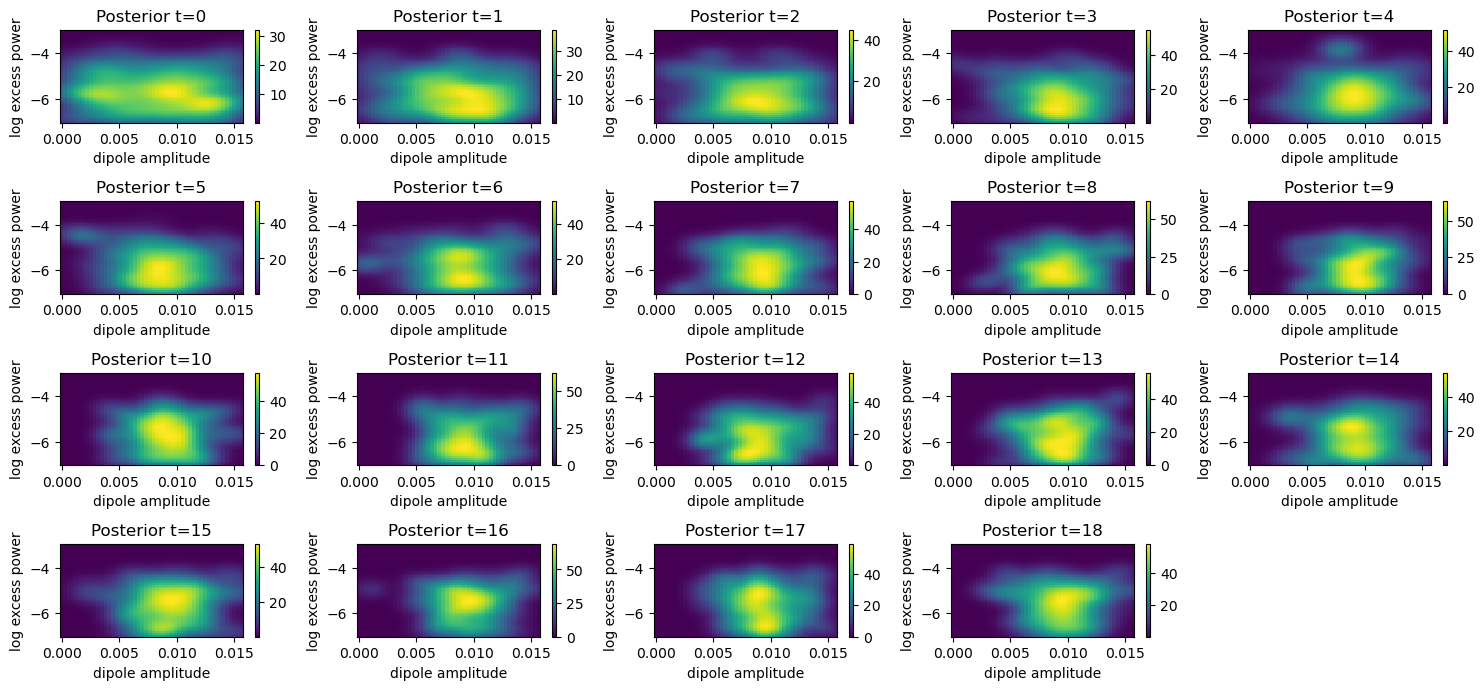

In [11]:
# evolution of the posterior
fig = plt.figure(figsize=(15, 10), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot((history.max_t + 1) // 3, 5, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

#### look at the maps

In [16]:
# load corrected and/or smoothed mean posterior mock
mean_mock = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside1_500mocks_20iters_base-rate-33.6330/accepted_samples/mean_mock.npy'))
mean_mock_smoothed = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside1_500mocks_20iters_base-rate-33.6330/accepted_samples/mean_mock_smoothed.npy'))
mean_mock_corr = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside1_500mocks_20iters_base-rate-33.6330/accepted_samples/mean_mock_corr.npy'))
mean_mock_corr_smoothed = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside1_500mocks_20iters_base-rate-33.6330/accepted_samples/mean_mock_corr_smoothed.npy'))

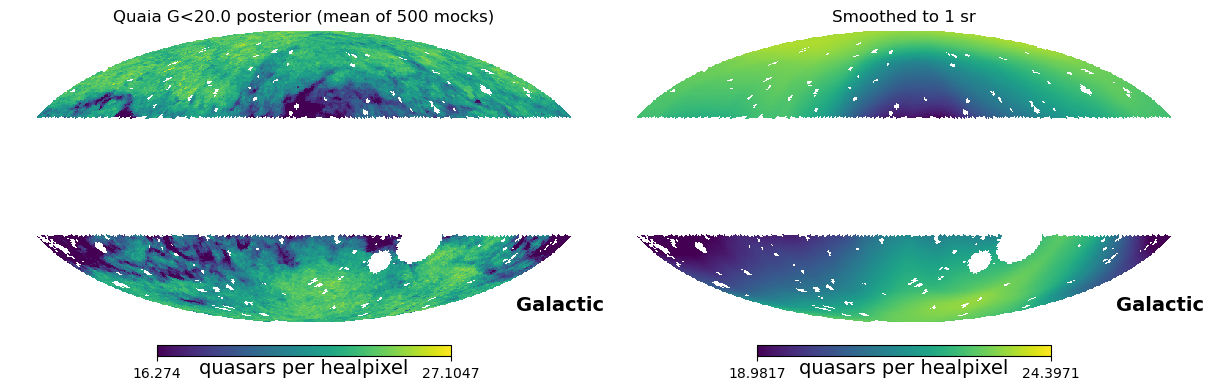

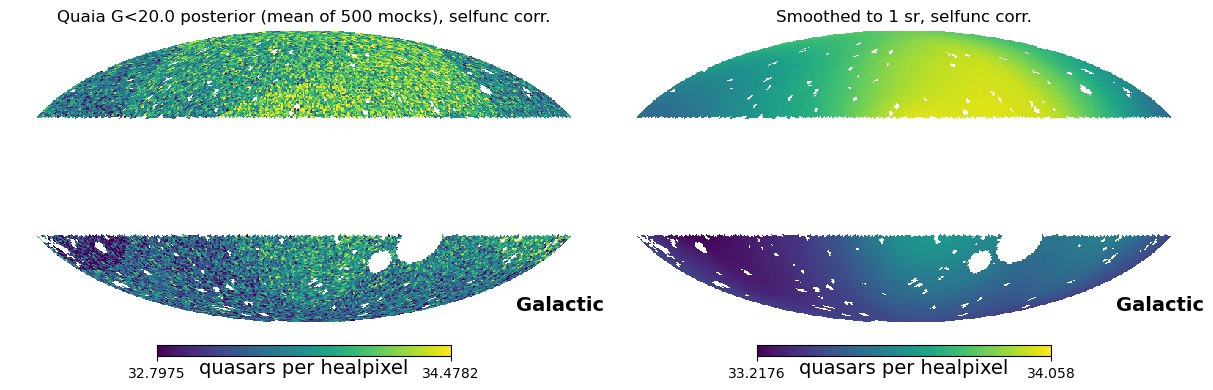

In [17]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock), np.nanstd(mean_mock)
hp.mollview(mean_mock, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks)', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock_corr), np.nanstd(mean_mock_corr)
hp.mollview(mean_mock_corr, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks), selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_corr_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

In [18]:
# overdensities

# unsmoothed:
odmap_quaia = quaia_qmap / np.nanmean(quaia_qmap)- 1
odmap_mock = mean_mock / np.nanmean(mean_mock) - 1
odmap_quaia_corr = quaia_qmap_corr / np.nanmean(quaia_qmap_corr) - 1
odmap_mock_corr = mean_mock_corr / np.nanmean(mean_mock_corr) - 1

# smoothed:
odmap_quaia_smoothed = quaia_qmap_smoothed / np.nanmean(quaia_qmap_smoothed) - 1
odmap_mock_smoothed = mean_mock_smoothed / np.nanmean(mean_mock_smoothed) - 1
odmap_quaia_corr_smoothed = quaia_qmap_corr_smoothed / np.nanmean(quaia_qmap_corr_smoothed) - 1
odmap_mock_corr_smoothed = mean_mock_corr_smoothed / np.nanmean(mean_mock_corr_smoothed) - 1

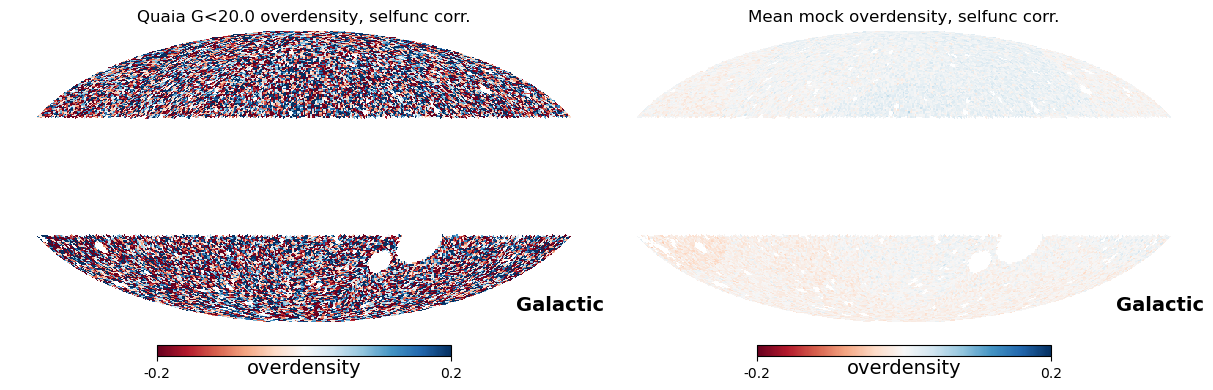

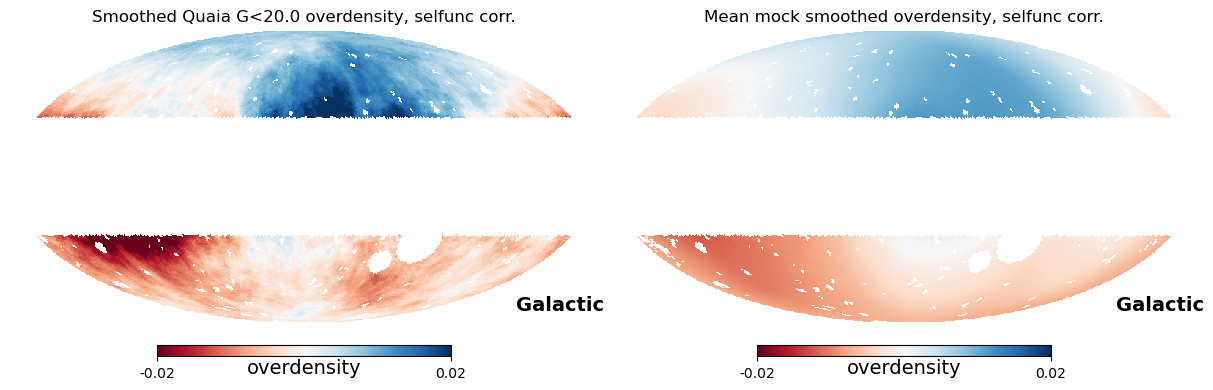

In [19]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, badcolor='w', min=-0.2, max=0.2)
hp.mollview(odmap_quaia_corr, title=f'Quaia G<20.0 overdensity, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(odmap_mock_corr, title='Mean mock overdensity, selfunc corr.', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, badcolor='w', min=-0.02, max=0.02)
hp.mollview(odmap_quaia_corr_smoothed, title=f'Smoothed Quaia G<20.0 overdensity, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(odmap_mock_corr_smoothed, title='Mean mock smoothed overdensity, selfunc corr.', sub=(1,2,2), **kwargs)

We easily see the dipole in the mocks, like we want! The other angular power averages out since only the kinematic dipole direction is fixed.

**Actually I'm realizing this is actually a fairly big "find", since given our discussions around the fake data tests, we've seen that the dipole amplitude is free to be positive or negative, so as far as the model is concerned, the dipole is free to be in the opposite direction if that best fits the data, but it doesn't!

In [20]:
# residuals! with selfunc-corrected map
res = odmap_mock_corr - odmap_quaia_corr
res_smoothed = tools.smooth_map(res, sr=1)

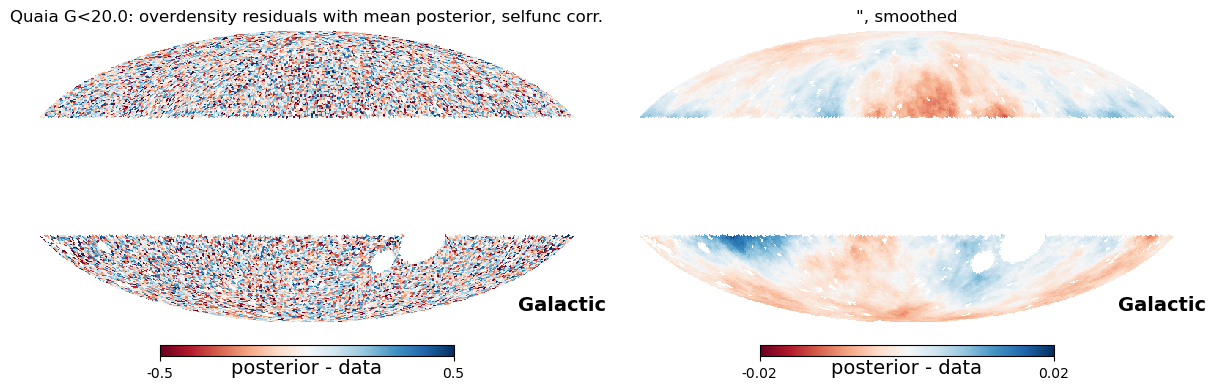

In [21]:
# residuals!
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='posterior - data', fig=fig, badcolor='w')
hp.mollview(res, min=-0.5, max=0.5, title='Quaia G<20.0: overdensity residuals with mean posterior, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(res_smoothed, min=-.02, max=.02, title='", smoothed', sub=(1,2,2), **kwargs)

### nside = 2

In [22]:
nside = 2
ngens = 14
res = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']
selfunc = res['selfunc']

Text(0.5, 0.98, 'Quaia ABC posteriors, nside=2, 13 generations')

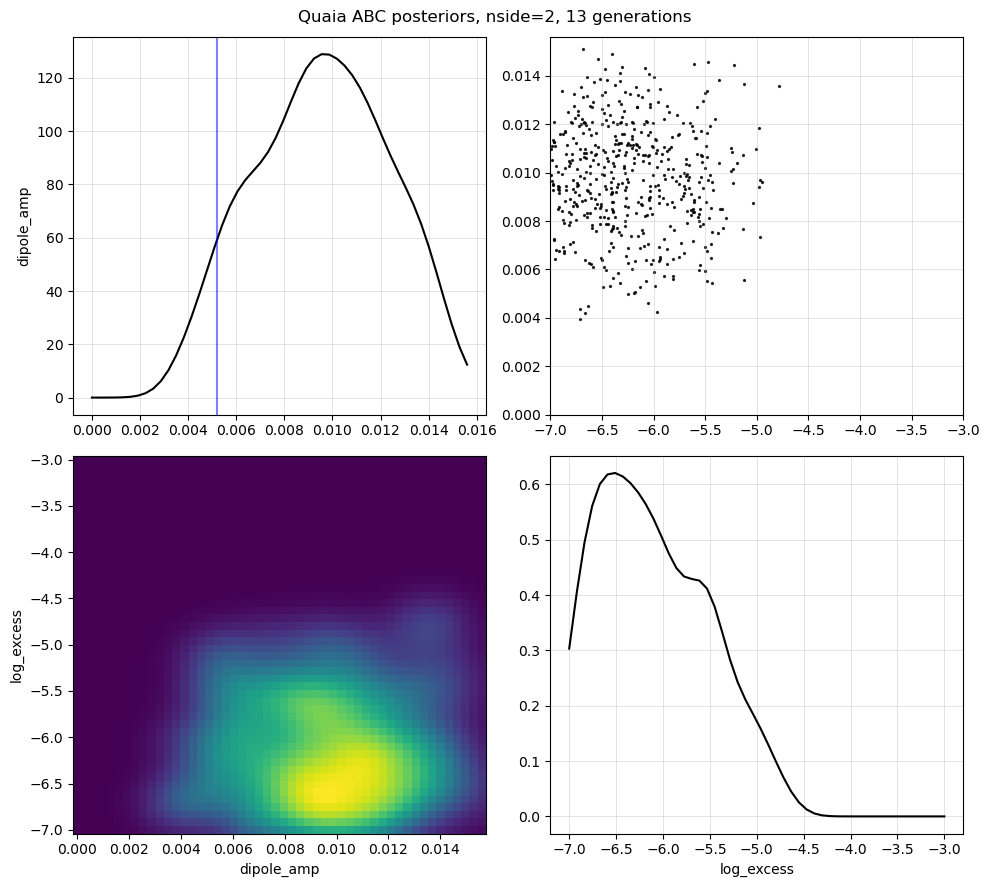

In [23]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)
    if i == 0:
        ax.axvline(0.0052, c='b', alpha=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'Quaia ABC posteriors, nside={nside}, {history.max_t} generations')

In [24]:
# median posteriors
np.median(df['dipole_amp']), np.median(df['log_excess'])

(0.009731445558522109, -6.276091802627045)

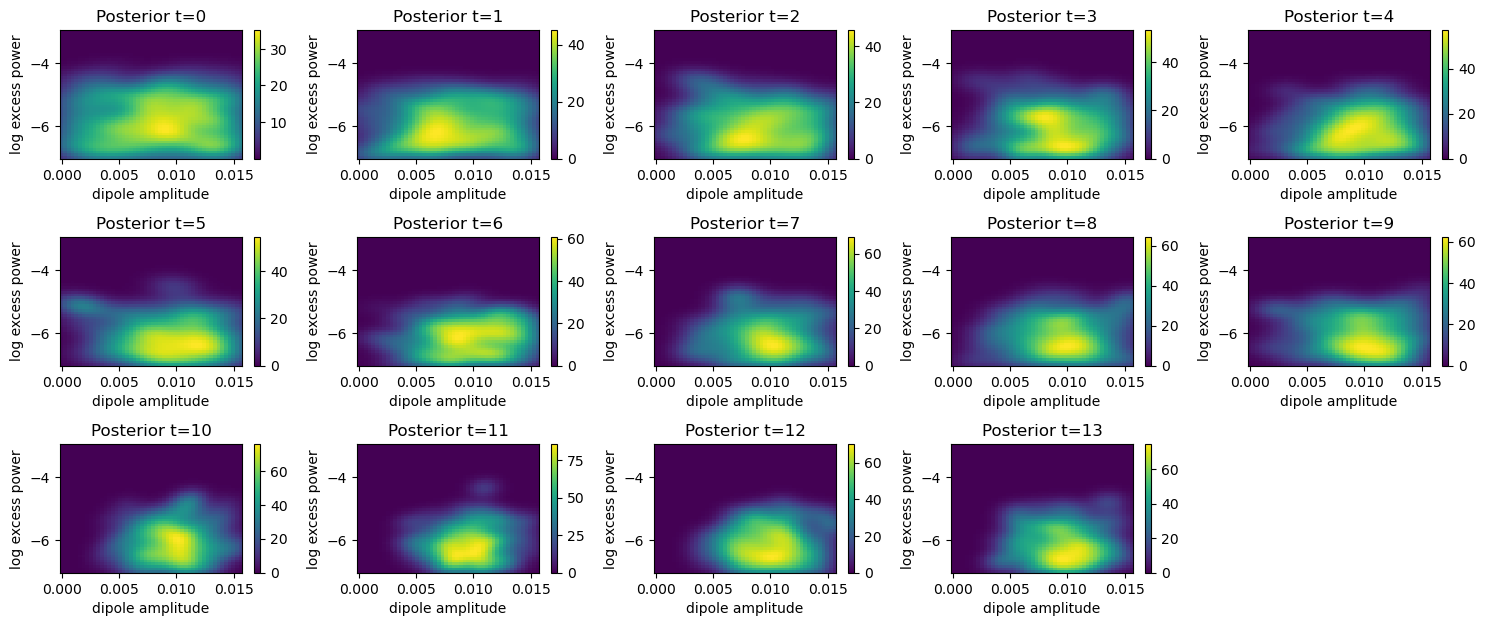

In [25]:
# evolution of the posterior
fig = plt.figure(figsize=(15, 8), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot((history.max_t + 1) // 3, 5, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

#### check out the maps

In [30]:
# load
mean_mock = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-33.6330/accepted_samples/mean_mock.npy'))
mean_mock_smoothed = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-33.6330/accepted_samples/mean_mock_smoothed.npy'))
mean_mock_corr = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-33.6330/accepted_samples/mean_mock_corr.npy'))
mean_mock_corr_smoothed = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-33.6330/accepted_samples/mean_mock_corr_smoothed.npy'))

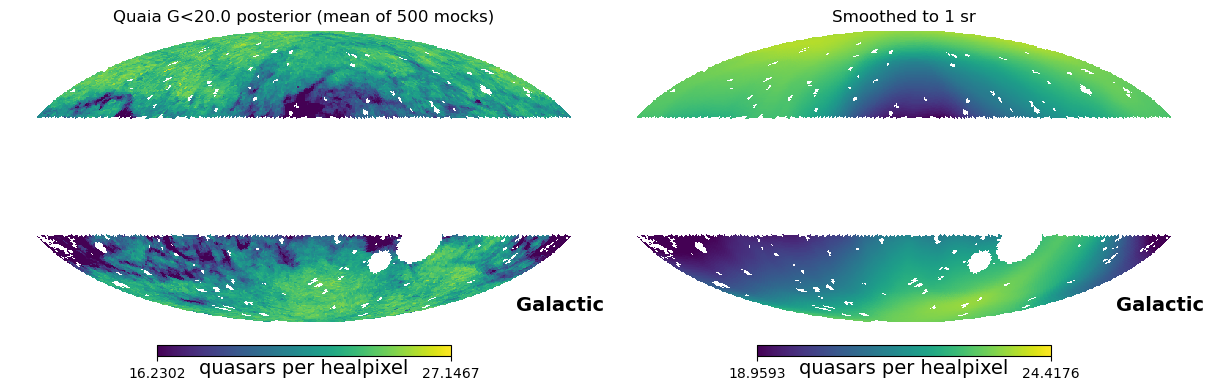

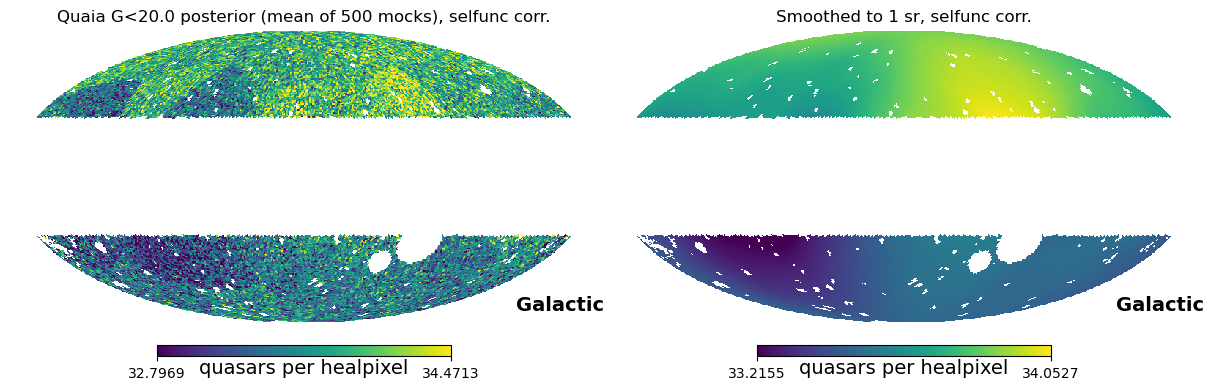

In [31]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock), np.nanstd(mean_mock)
hp.mollview(mean_mock, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks)', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock_corr), np.nanstd(mean_mock_corr)
hp.mollview(mean_mock_corr, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks), selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_corr_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

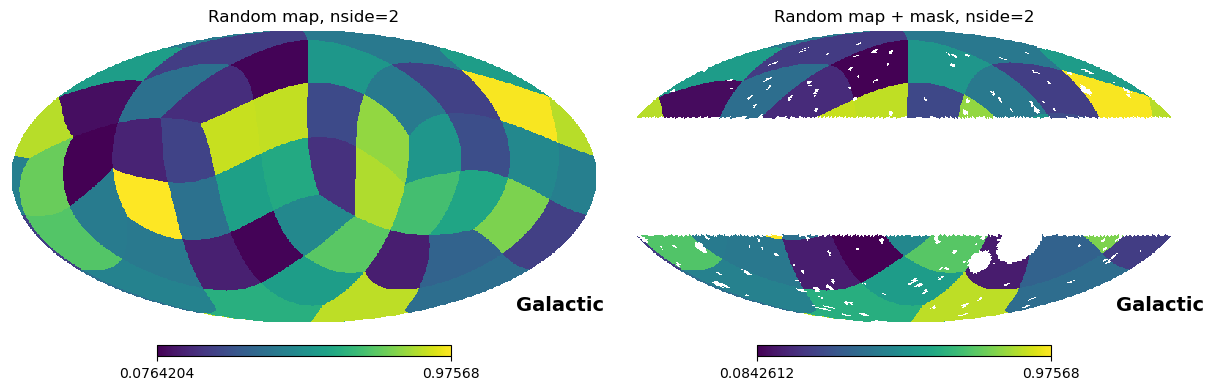

In [32]:
# is this an nside 2 pattern with healpix?
testmap = np.random.uniform(size=hp.nside2npix(2))
testmap_ug_masked = hp.ud_grade(testmap, 64)
testmap_ug_masked[selfunc_quaia == 0] = np.nan
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], title='')
hp.mollview(testmap, coord=['C','G'], title='Random map, nside=2', sub=(1,2,1))
hp.mollview(testmap_ug_masked, coord=['C','G'], title='Random map + mask, nside=2', sub=(1,2,2), badcolor='w')

yes I think it is! does this suggest that we should be using higher nside ?

### nside = 4

In [33]:
nside = 4
ngens = 14
res = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']
selfunc = res['selfunc']

Text(0.5, 0.98, 'Quaia ABC posteriors, nside=4, 13 generations')

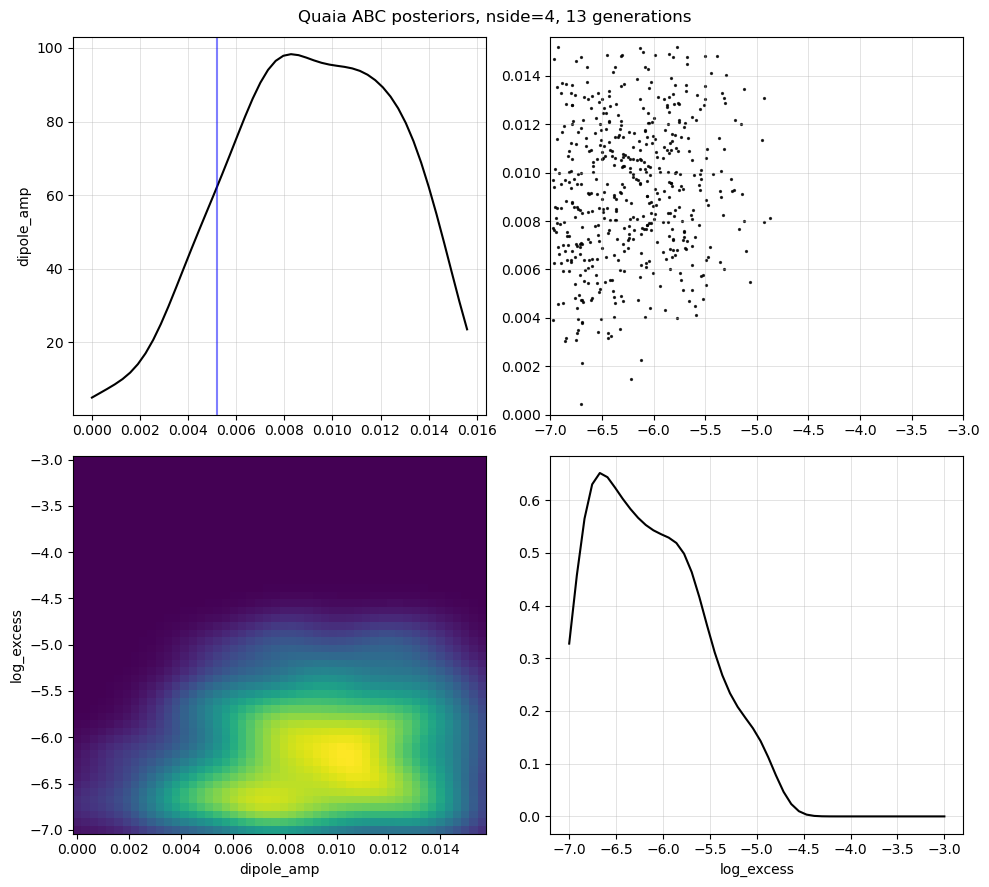

In [34]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)
    if i == 0:
        ax.axvline(0.0052, c='b', alpha=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'Quaia ABC posteriors, nside={nside}, {history.max_t} generations')

In [35]:
# median posteriors
np.median(df['dipole_amp']), np.median(df['log_excess'])

(0.009263072099846642, -6.250973046600254)

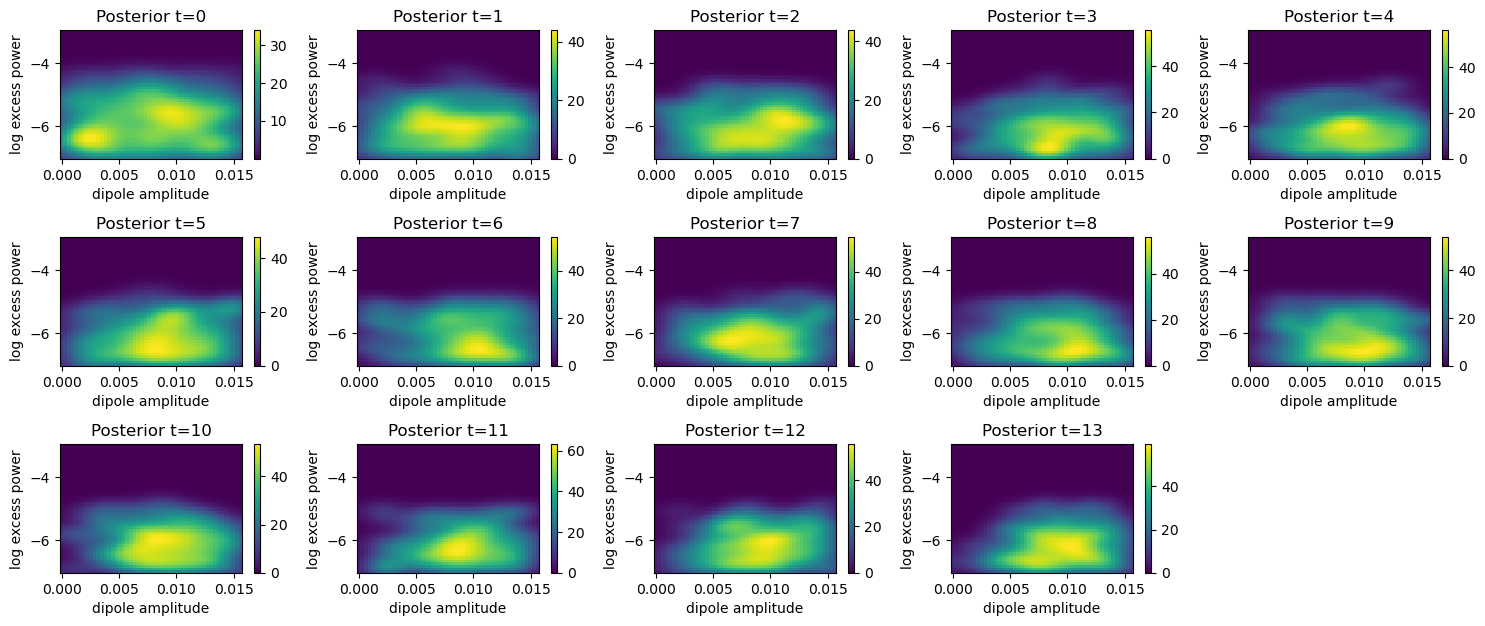

In [36]:
# evolution of the posterior
fig = plt.figure(figsize=(15, 8), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot((history.max_t + 1) // 3, 5, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

#### look at the maps

In [37]:
# posterior mocks
nmocks = 500
mean_mock = np.zeros_like(quaia_qmap)
for i in range(nmocks):
    mock = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}',
                                'accepted_samples', f'mock{i}.npy')).astype(float)
    mock[mock == 0.] = np.nan
    mean_mock += mock
mean_mock /= nmocks

In [39]:
# smooth
mean_mock_smoothed = tools.smooth_map(mean_mock, sr=1)
# correct by the selection function
mean_mock_corr = mean_mock / selfunc_quaia
mean_mock_corr_smoothed = tools.smooth_map(mean_mock_corr, sr=1)

In [40]:
# save
np.save(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock.npy'), mean_mock)
np.save(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_corr.npy'), mean_mock_corr)
np.save(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_smoothed.npy'), mean_mock_smoothed)
np.save(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_corr_smoothed.npy'), mean_mock_corr_smoothed)

In [41]:
# load
mean_mock = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock.npy'))
mean_mock_corr = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_corr.npy'))
mean_mock_smoothed = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_smoothed.npy'))
mean_mock_corr_smoothed = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_500mocks_{ngens}iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_corr_smoothed.npy'))

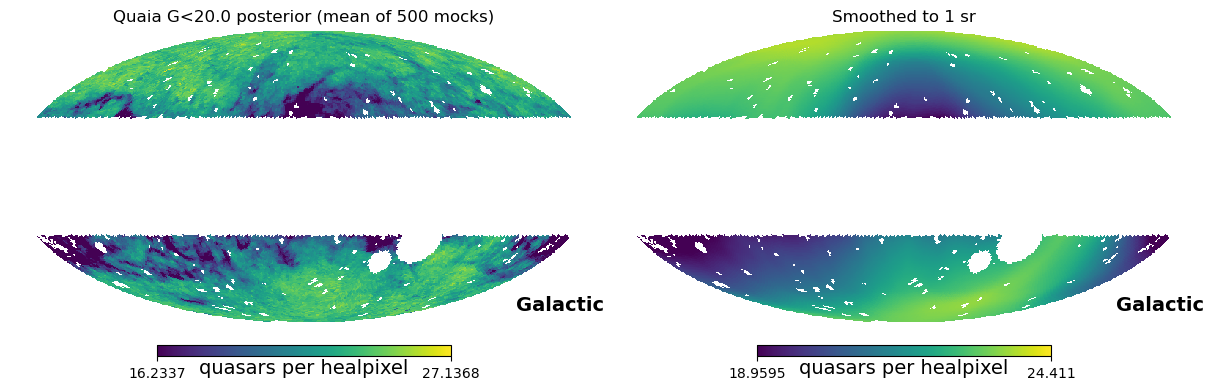

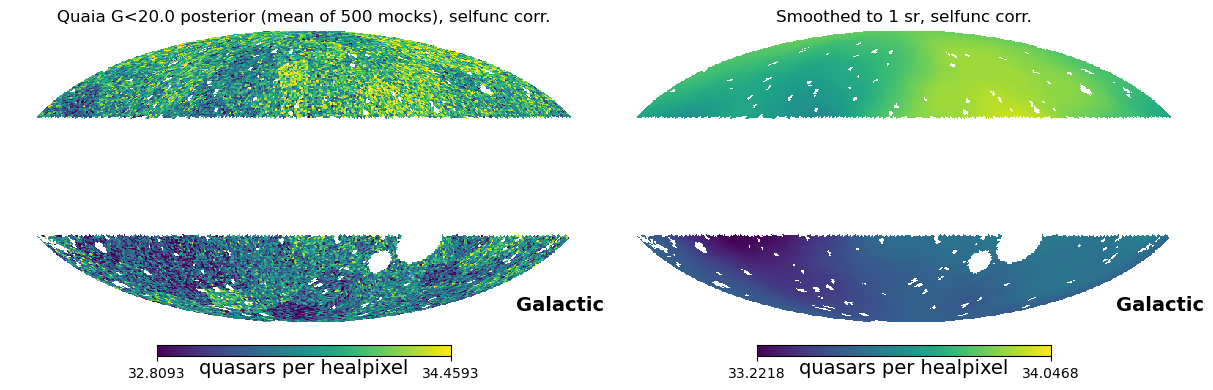

In [42]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock), np.nanstd(mean_mock)
hp.mollview(mean_mock, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks)', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock_corr), np.nanstd(mean_mock_corr)
hp.mollview(mean_mock_corr, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks), selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_corr_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

### CatWISE

#### with `catwise_pluszodis` selfunc

In [29]:
nside = 1
res = np.load(os.path.join(resdir, f'ABC/catwise_dipole_excess_nside{nside}_500mocks_20iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']
selfunc = res['selfunc']

Text(0.5, 0.98, 'CatWISE ABC posteriors, nside=1, 20 generations')

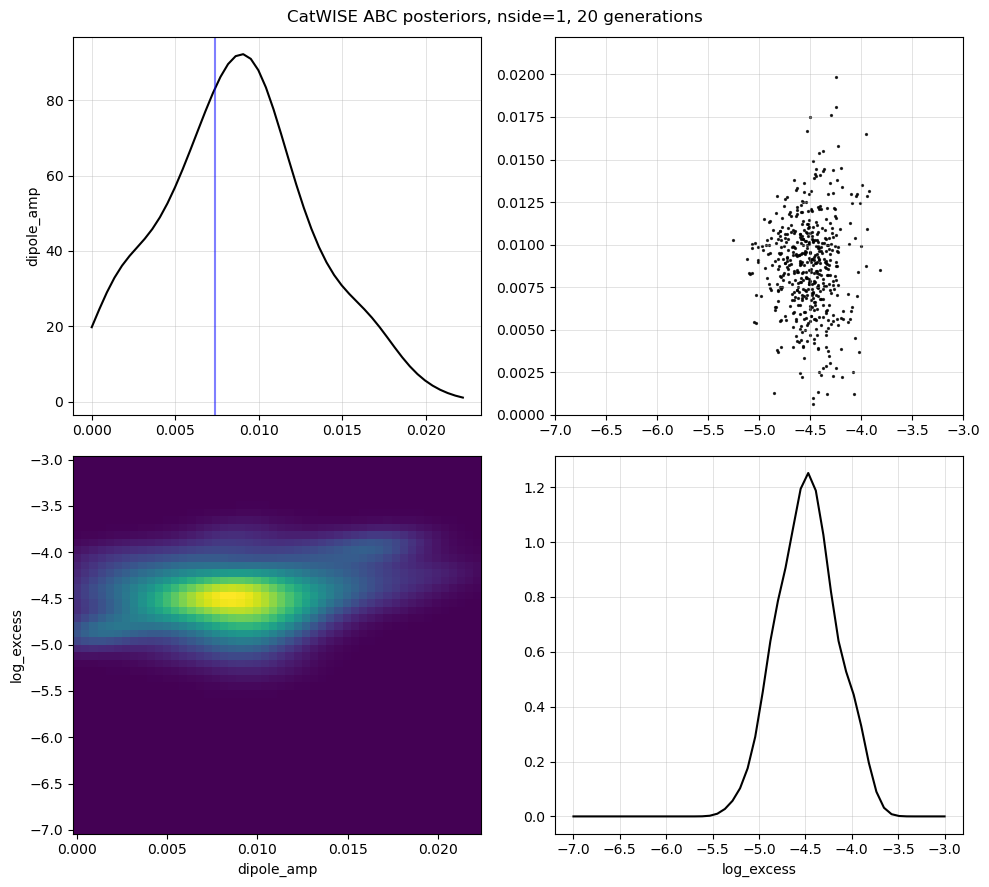

In [30]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)
    if i == 0:
        ax.axvline(0.0074, c='b', alpha=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'CatWISE ABC posteriors, nside={nside}, {history.max_t} generations')

In [31]:
# median posteriors
np.median(df['dipole_amp']), np.median(df['log_excess'])

(0.00891426710695714, -4.5071511538472855)

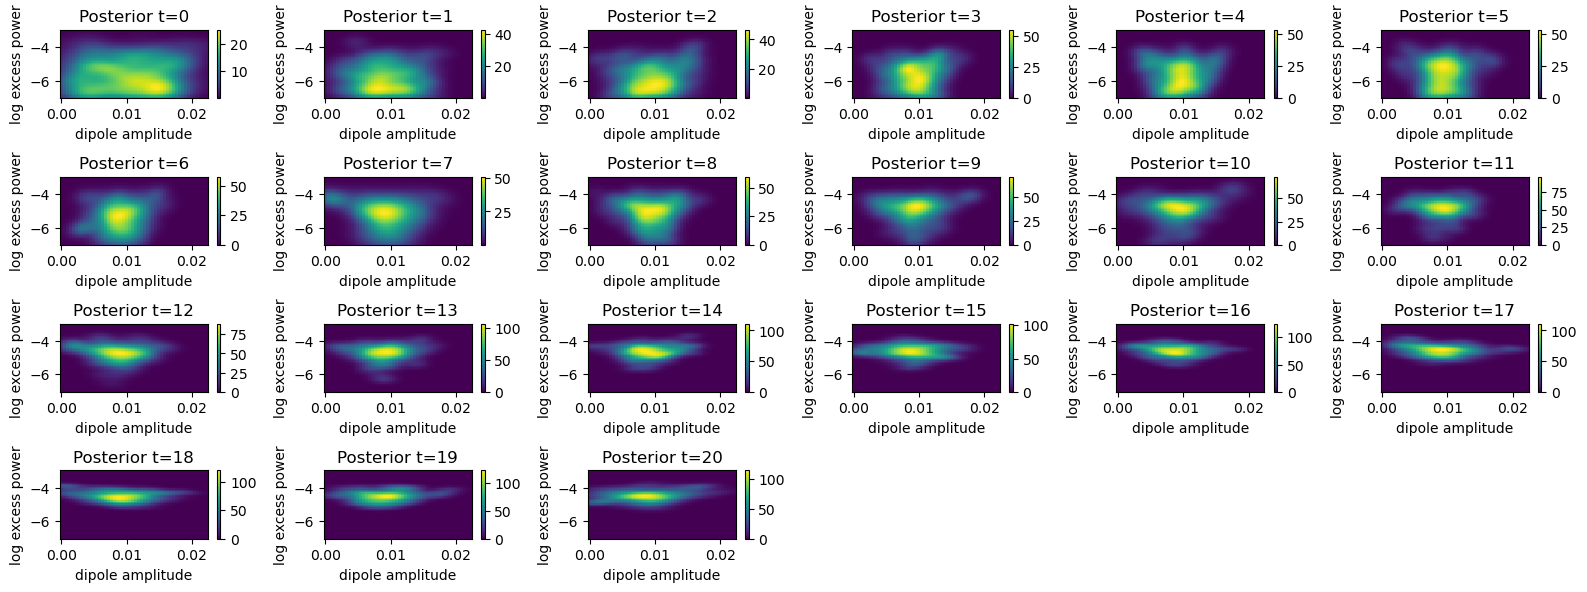

In [32]:
# evolution of the posterior
fig = plt.figure(figsize=(16, 10), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot((history.max_t + 1) // 3, 6, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

#### look at the maps

In [34]:
# posterior mocks
nmocks = 500
mean_mock = np.zeros_like(catwise_qmap)
for i in range(nmocks):
    mock = np.load(os.path.join(resdir, 'ABC/catwise_dipole_excess_nside1_500mocks_20iters_base-rate-77.4495/accepted_samples',
                                f'mock{i}.npy')).astype(float)
    mock[mock == 0.] = np.nan
    mean_mock += mock
mean_mock /= nmocks

In [35]:
# smooth
mean_mock_smoothed = tools.smooth_map(mean_mock, sr=1)
# correct by the selection function
mean_mock_corr = mean_mock / selfunc_catwise
mean_mock_corr_smoothed = tools.smooth_map(mean_mock_corr, sr=1)

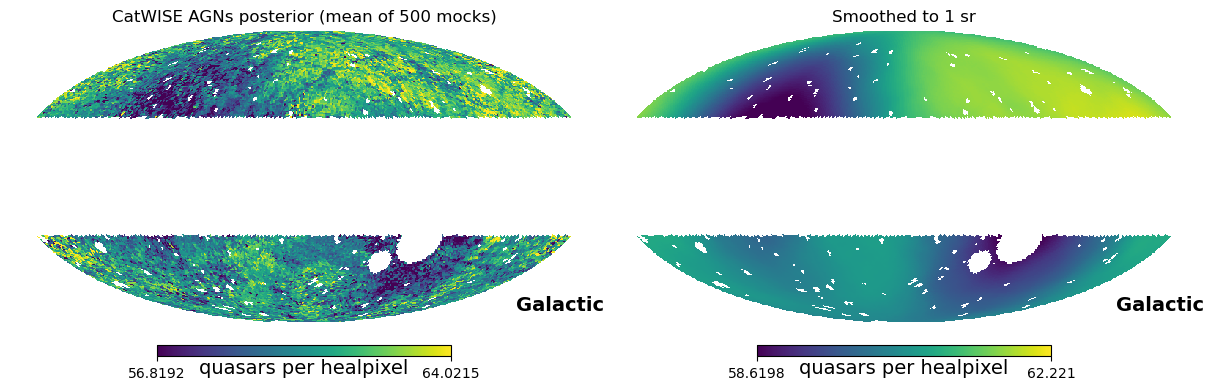

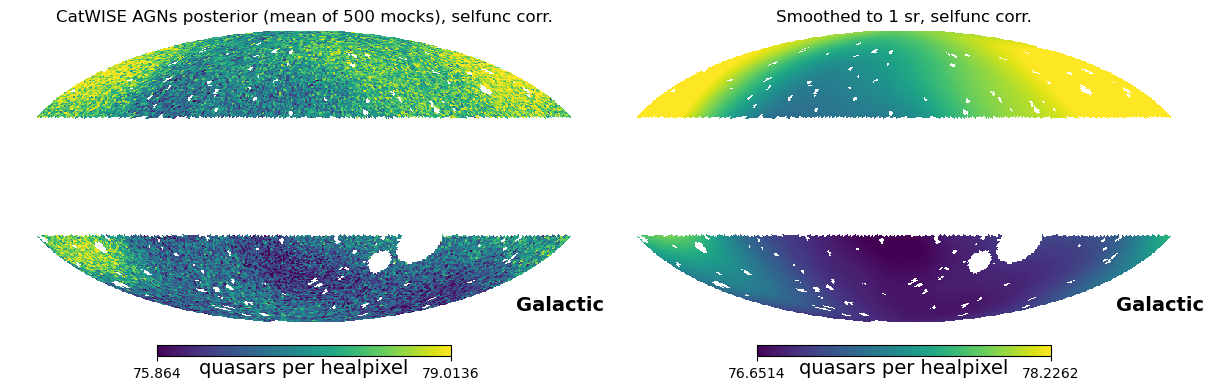

In [36]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock), np.nanstd(mean_mock)
hp.mollview(mean_mock, min=mean-2*std, max=mean+2*std, title=f'CatWISE AGNs posterior (mean of {nmocks} mocks)', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock_corr), np.nanstd(mean_mock_corr)
hp.mollview(mean_mock_corr, min=mean-2*std, max=mean+2*std, title=f'CatWISE AGNs posterior (mean of {nmocks} mocks), selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_corr_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

In [37]:
# overdensities
odmap_catwise = catwise_qmap_smoothed / np.nanmean(catwise_qmap_smoothed) - 1
odmap_mock = mean_mock_smoothed / np.nanmean(mean_mock_smoothed) - 1

# and the selfunc corrected
odmap_catwise_corr = catwise_qmap_corr_smoothed / np.nanmean(catwise_qmap_corr_smoothed) - 1
odmap_mock_corr = mean_mock_corr_smoothed / np.nanmean(mean_mock_corr_smoothed) - 1

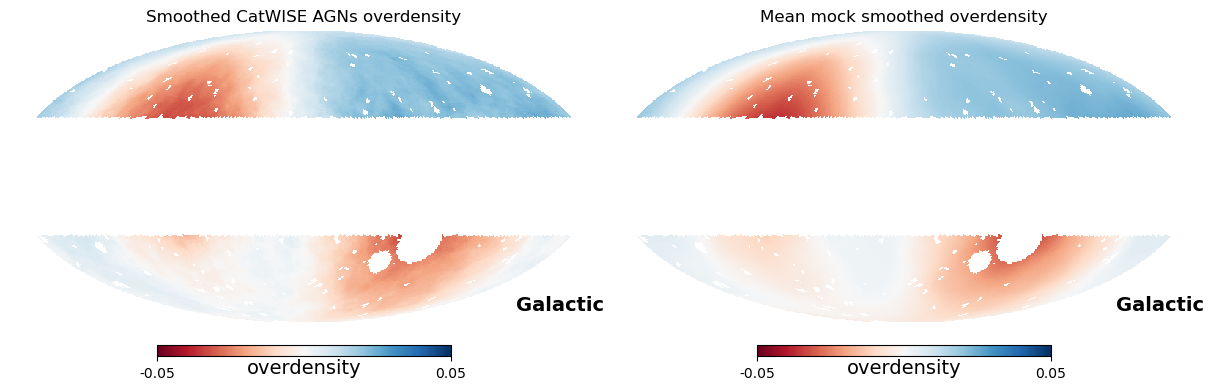

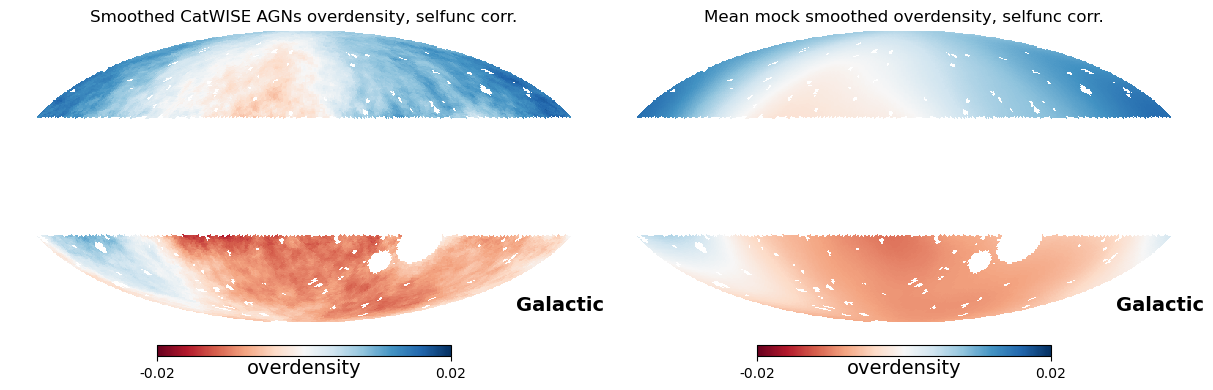

In [39]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, badcolor='w', min=-0.05, max=0.05)
hp.mollview(odmap_catwise, title=f'Smoothed CatWISE AGNs overdensity', sub=(1,2,1), **kwargs)
hp.mollview(odmap_mock, title='Mean mock smoothed overdensity', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, badcolor='w', min=-0.02, max=0.02)
hp.mollview(odmap_catwise_corr, title=f'Smoothed CatWISE AGNs overdensity, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(odmap_mock_corr, title='Mean mock smoothed overdensity, selfunc corr.', sub=(1,2,2), **kwargs)

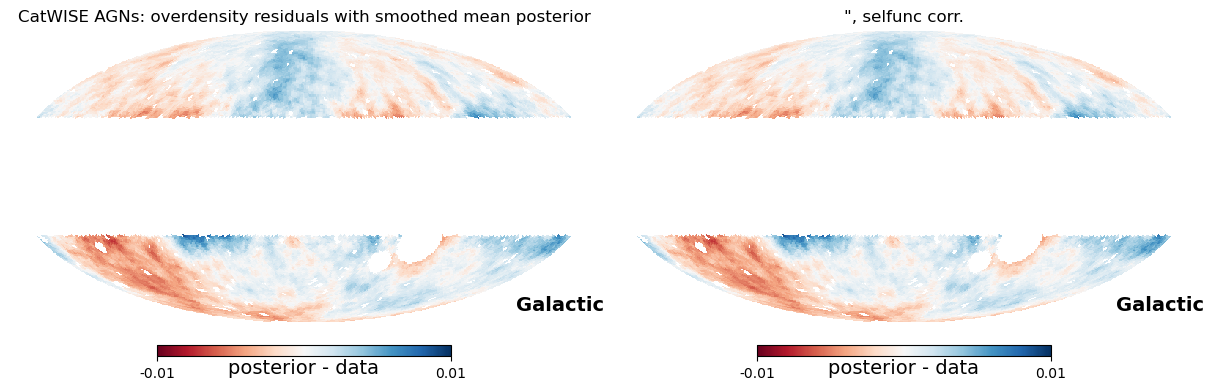

In [42]:
# residuals!
fig = plt.figure(figsize=(12,4))
res = odmap_mock - odmap_catwise
res_corr = odmap_mock_corr - odmap_catwise_corr
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='posterior - data', fig=fig, badcolor='w')
hp.mollview(res, min=-.01, max=.01, title='CatWISE AGNs: overdensity residuals with smoothed mean posterior', sub=(1,2,1), **kwargs)
hp.mollview(res_corr, min=-.01, max=.01, title='", selfunc corr.', sub=(1,2,2), **kwargs)

### nside = 2

In [45]:
nside = 2
res = np.load(os.path.join(resdir, f'ABC/catwise_dipole_excess_nside{nside}_500mocks_14iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']
selfunc = res['selfunc']

Text(0.5, 0.98, 'CatWISE ABC posteriors, nside=2, 13 generations')

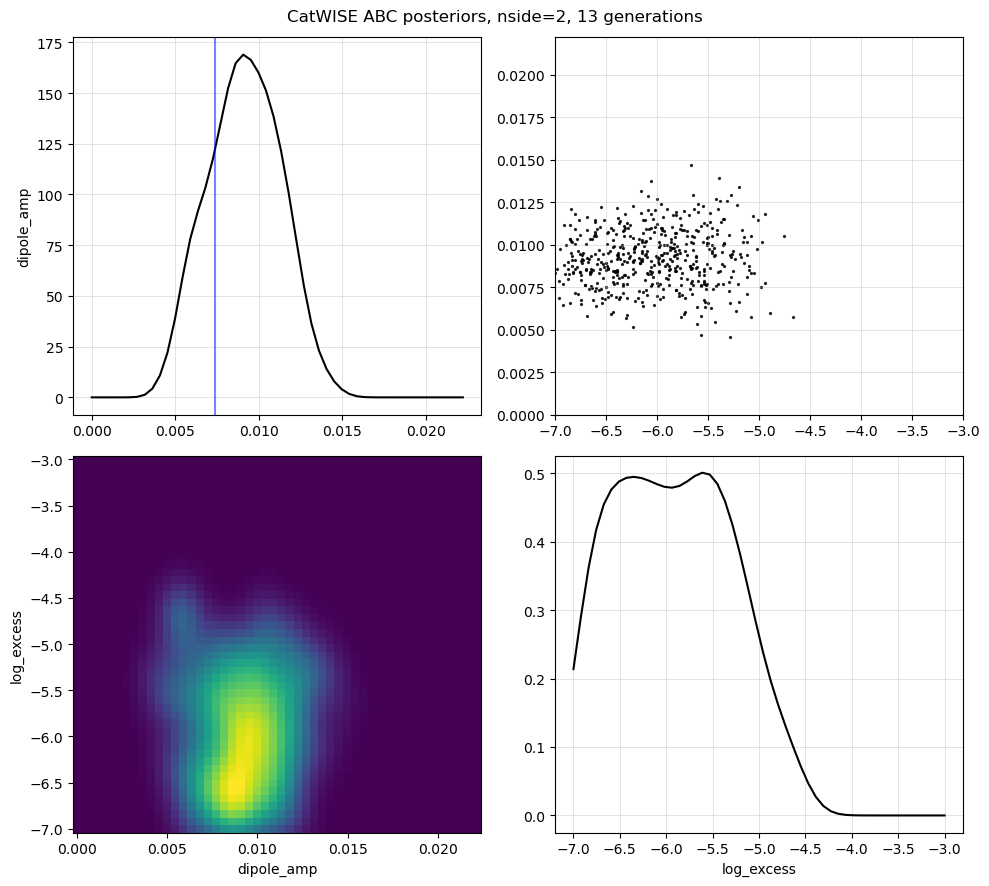

In [46]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)
    if i == 0:
        ax.axvline(0.0074, c='b', alpha=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'CatWISE ABC posteriors, nside={nside}, {history.max_t} generations')

In [47]:
# median posteriors
np.median(df['dipole_amp']), np.median(df['log_excess'])

(0.009168935697909233, -6.044217808713311)

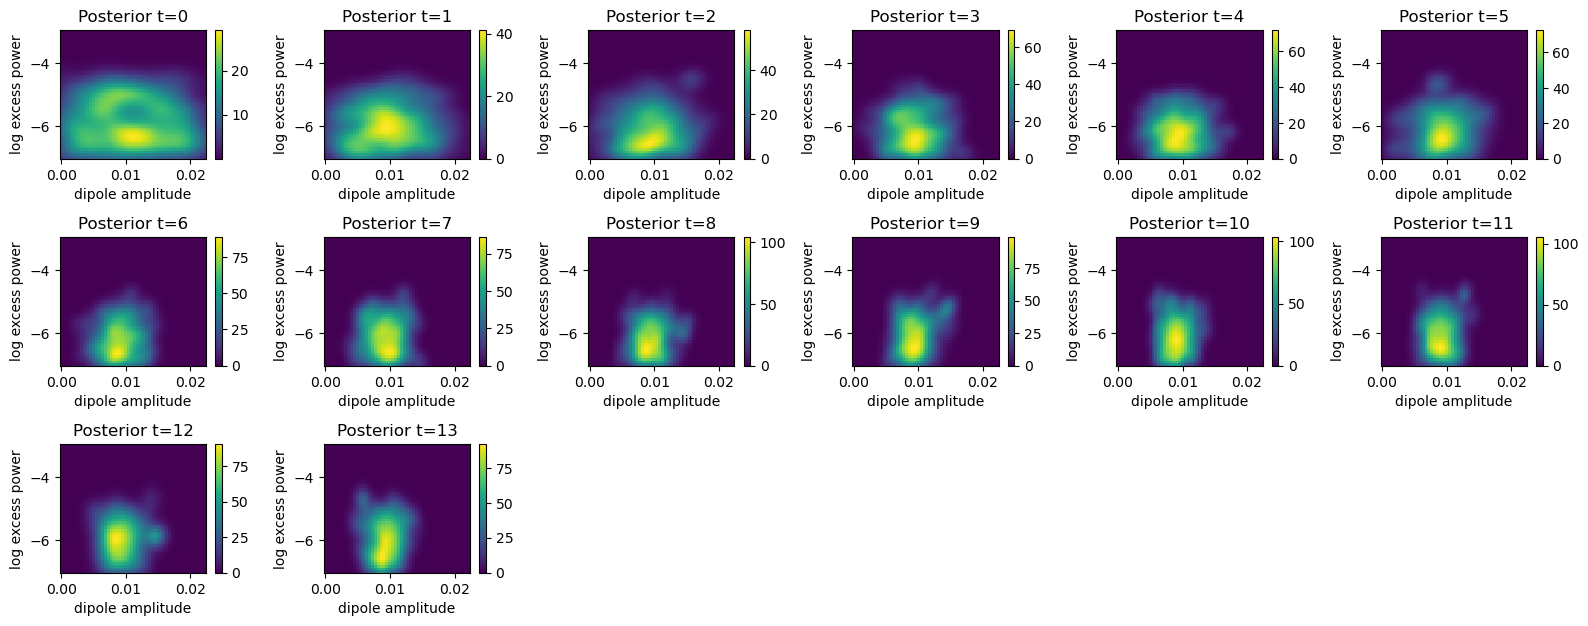

In [49]:
# evolution of the posterior
fig = plt.figure(figsize=(16, 8), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot((history.max_t + 1) // 3, 6, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

#### Cells

In [36]:
# data
Lambda = 0.
ell_max = 8
odmap = dipole.overdensity_map(catwise_qmap_masked, selfunc)
ells, Cells, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(odmap,
                                                        Lambda=Lambda,
                                                        max_ell=ell_max,
                                                        selfunc=selfunc,
                                                        return_alms=True)

In [37]:
# load posterior results and take mean
mock_Cells = []
for i in range(nmocks):
    Cells_res = np.load(os.path.join(resdir, f'ABC/catwise_dipole_excess_nside1_500mocks_20iters_base-rate-77.4495/accepted_samples_Cells',
                                     f'Cells_mock{i}.npy'), allow_pickle=True).item()
    assert np.all(Cells_res['ells'] == ells)
    mock_Cells.append(Cells_res['Cells'])
mean_Cells_mock = np.mean(np.array(mock_Cells), axis=0)
std_Cells_mock = np.std(np.array(mock_Cells), axis=0)

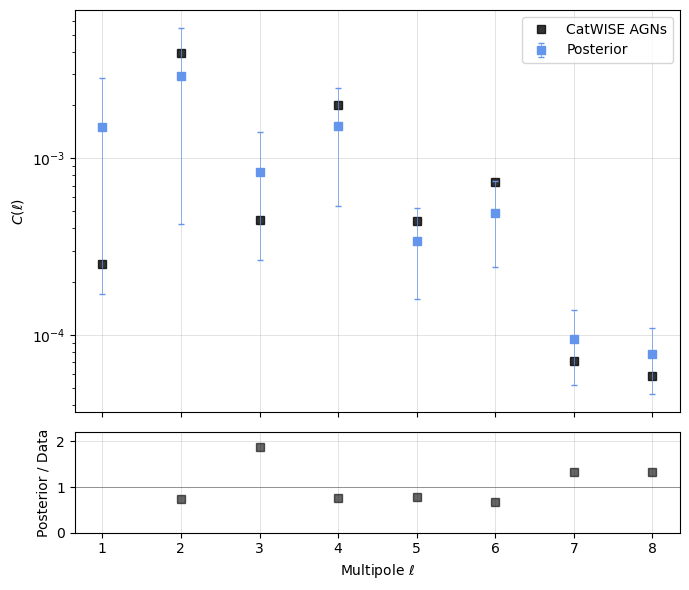

In [38]:
fig = plt.figure(figsize=(7,6), tight_layout=True)

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1., 0.25])

ax0 = fig.add_subplot(gs[0])
kwargs = dict(marker='s', ls='None')
ax0.plot(ells[1:], Cells[1:], c='k', alpha=0.8, label='CatWISE AGNs', **kwargs)
ax0.errorbar(ells[1:], mean_Cells_mock[1:], yerr=std_Cells_mock[1:], capsize=2, lw=0.5, c='cornflowerblue',
            label='Posterior', **kwargs)
ax0.set_ylabel(r'$C(\ell)$')
ax0.legend()
ax0.semilogy()
ax0.set_xticklabels([])

ax1 = fig.add_subplot(gs[1])
ax1.plot(ells[1:], mean_Cells_mock[1:] / Cells[1:], c='k', alpha=0.6, **kwargs)
ax1.set_xlabel(r'Multipole $\ell$')
ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
ax1.set_ylim(0., 2.2)
ax1.set_ylabel('Posterior / Data')

for ax in (ax0, ax1):
    ax.grid(alpha=0.5, lw=0.5)

#### check selection functions

In [8]:
selfunc_dir = os.path.join(resdir, '../data/catalogs/catwise_agns/selfuncs')

# everything except zodi
sf_catwise = hp.read_map(os.path.join(selfunc_dir, f'selection_function_NSIDE64_catwise.fits'))
# pluszodis
sf_catwise_pluszodis = hp.read_map(os.path.join(selfunc_dir, f'selection_function_NSIDE64_catwise_pluszodis.fits'))
# elat correction
sf_catwise_elatcorr = hp.read_map(os.path.join(selfunc_dir, f'selection_function_NSIDE64_catwise_elatcorr.fits'))

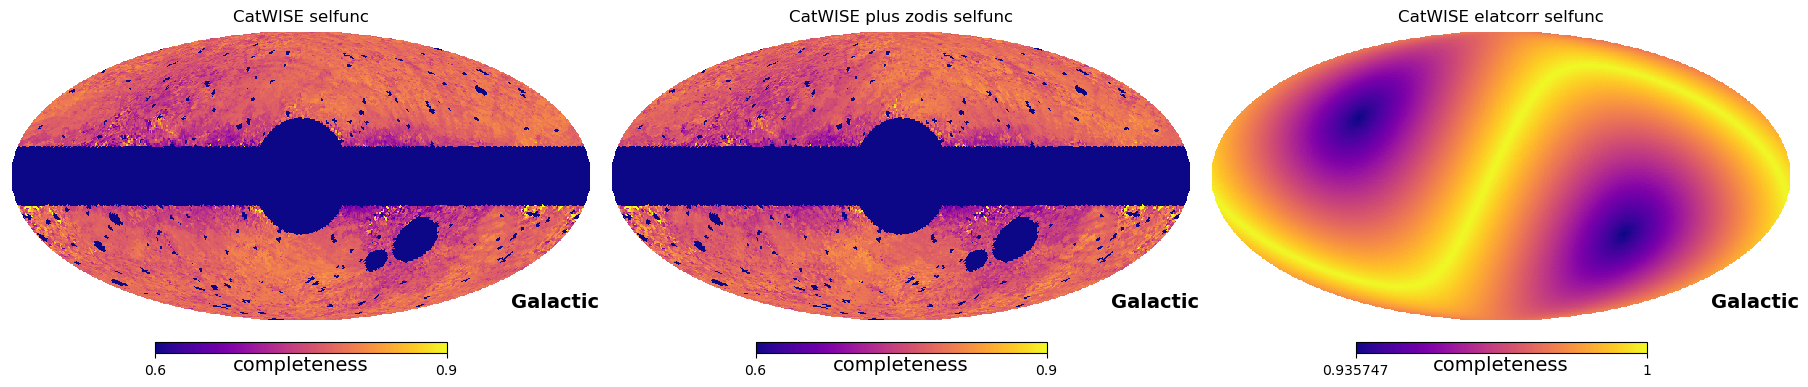

In [9]:
fig = plt.figure(figsize=(18,4))
kwargs = dict(coord=['C','G'], cmap='plasma', badcolor='w', unit='completeness', fig=fig)
hp.mollview(sf_catwise, title='CatWISE selfunc', sub=(1,3,1), min=0.6, max=0.9, **kwargs)
hp.mollview(sf_catwise_pluszodis, title='CatWISE plus zodis selfunc', min=0.6, max=0.9, sub=(1,3,2), **kwargs)
hp.mollview(sf_catwise_elatcorr, title='CatWISE elatcorr selfunc', sub=(1,3,3), **kwargs)

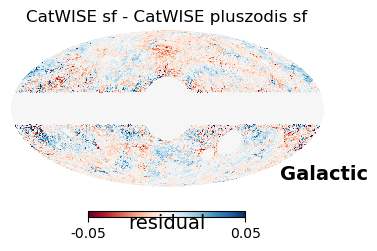

In [10]:
hp.mollview(sf_catwise - sf_catwise_pluszodis, cmap='RdBu', coord=['C','G'], unit='residual',
            min=-0.05, max=0.05, title='CatWISE sf - CatWISE pluszodis sf', sub=(1,2,1))